In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#import pyneb as pn

import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
from scipy.interpolate import Akima1DInterpolator
from scipy import optimize as opt
import sys
import emcee
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from astropy.table import Table

In [2]:
OIII4960 = 4958.911
OIII5007 = 5006.843
OIII4363 = 4363.210
h_beta = 4861.333
h_alpha = 6562.819
SII6716 = 6716.440
SII6731 = 6730.810
OII3726= 3726.032
OII3729= 3728.815

In [3]:
def OIII_ratio(oiii4363, oiii4960, oiii5007):
    """Calculate the logarithmic OIII ratio."""
    ratio = np.log10(oiii4363 / (oiii4960 + oiii5007))
    return ratio

def effective_temp(x):
    """Calculate the effective temperature from the OIII ratio."""
    log_Te = (3.5363 + 7.2939 * x) / (1.0000 + 1.6298 * x - 0.1221 * (x ** 2) - 0.0074 * (x ** 3))
    T_e = 10 ** log_Te
    return T_e

def metallicity(T_e):
    """Calculate the metallicity as 12 + log(O/H)."""
    t_e = T_e / 1e4  # Scale temperature to 10^4 K units
    O_H = 9.72 - 1.7 * t_e + 0.32 * (t_e ** 2)
    return O_H

In [24]:
def gaussian(x, A, mu, sigma):
    
    '''
    Gaussian Model for Line Fitting
    '''
    
    return A * np.exp(-(x - mu)**2/ (sigma**2))

def line(x, b):
    
    '''
    Continuum of the spectra
    '''
    
    return  np.ones(len(x))*b

def line_model(x, b, sigma, sigma_h_beta, amp_4363, amp_5007, mu5007, amp_hbeta):
    
    '''
    Emission Line model using Gaussian and the continuum
    ''' 
 
    #return gaussian(x, A1, mu1, sigma) +gaussian(x, A2, mu2, sigma)  + gaussian(x, A3, mu3, sigma) +line(x, b)
    return gaussian(x, amp_4363, (OIII4363/OIII5007)*mu5007, sigma) +gaussian(x, amp_5007/2.5, (OIII4960/OIII5007)*mu5007, sigma)  + gaussian(x, amp_5007, mu5007, sigma)  + gaussian(x, amp_hbeta, ((h_beta/OIII5007)*mu5007), sigma_h_beta)+line(x, b)


def log_likelihood(theta, x, y, yerr):
    
    ################
    
    # The value we are trying to fit
    #A, mu, sigma, m, b = theta
    
    #Making the model of the emission line
    model = line_model(x, *theta)
    
    #getting the log likelihood, this is similar to chi2
    lnL = -0.5 * np.sum((y - model) ** 2 / yerr**2)
    
    return lnL

def log_prior(theta, wave_OIII5007, Amp_max):
    
    #Theta values that goes into our Gaussian Model
    b, sigma, sigma_h_beta, amp_4363, amp_5007, mu5007, amp_hbeta = theta
    
    left_mu3 = wave_OIII5007 -5  #had to change these as well this is how much mu can vary
    right_mu3 = wave_OIII5007 +5 #had to change these as well this is how much mu can vary
    
    #min and max amplitude of the emission line
    min_A = 0
    max_A = Amp_max * 2
    
    sigma_window_left = .0001 #had to change these for the input spectra these are left bounds for sigma
    sigma_window_right = 50 #had to change these for the input spectra these are right bounds for sigma
        
    if  (0 < amp_5007 < max_A) &(0 < amp_4363 < max_A) &(0 < amp_hbeta < max_A) &(left_mu3 <= mu5007 <= right_mu3)& (sigma_window_left <= sigma < sigma_window_right) & (sigma_window_left <= sigma_h_beta < sigma_window_right)& (b > 0):
        return 0.0
    else:
        return -np.inf
    
  
    
def log_probability(theta, x, y, yerr, wave_OIII5007, Amp_max):
    
    lp = log_prior(theta, wave_OIII5007, Amp_max)
    if not np.isfinite(lp):
        #print('Probability is infinite')
        return -np.inf
    prob = lp + log_likelihood(theta, x, y, yerr)
    #print(f'Prob:{prob:.3E}')
    return prob


def initial_fits(wave, spectrum, err_spec, window, diagnose = False):
    
    guess_ampOIII5007 = np.amax(spectrum)
    guess_muOIII5007 = OIII5007
    
    mask_h_beta = (wave>4850) & (wave <4870)
    guess_amp_h_beta = np.amax(spectrum[mask_h_beta])
   
    mask_4363 = (wave>4000) & (wave <4400)
    guess_ampOIII4363 = np.amax(spectrum[mask_4363])
    

    interp_mask = np.isfinite(spectrum)
    spec_interp = Akima1DInterpolator(wave[interp_mask], spectrum[interp_mask])
    
    x = np.linspace(wave[0], wave[-1], 10000)
    
    spec = spec_interp(x)
    
    half_max = np.amax(spec)/2
    
    idx = np.where(spec > half_max)[0]
    
    wave_left, wave_right = x[idx[0]], x[idx[-1]]
    
    guess_sigma = (wave_right - wave_left)/2

    if diagnose == True:
        
        print('Minimization Guesses')
        print(f"OIII4363 Amplitude: {guess_ampOIII4363}")
        print(f"OIII5007 Amplitude: {guess_ampOIII5007}")
        print(f"H_beta Amplitude: {guess_amp_h_beta}")
        print(f"Center OIII5007: {guess_muOIII5007}")
        print(f"sigma: {guess_sigma}")
        print(f"b: {np.median(window)}")
        print() 
        
    if np.median(spectrum) < 0:
        low_bound_negative = np.median(spectrum)*2
        high_bound_negative = np.median(spectrum)/2
        low_bounds = [low_bound_negative, 0, 0, guess_ampOIII4363/2 ,guess_ampOIII5007/2,guess_muOIII5007-10 ,guess_amp_h_beta/2]
        high_bounds = [high_bound_negative, 2*guess_sigma, 2*guess_sigma, guess_ampOIII4363*2 ,guess_ampOIII5007*2,guess_muOIII5007+10,guess_amp_h_beta*2] 
    
    else:
        low_bound_positive = np.median(spectrum)/2
        high_bound_positive = np.median(spectrum)*2
        low_bounds = [low_bound_positive, 0, 0, guess_ampOIII4363/2 ,guess_ampOIII5007/2,guess_muOIII5007-10,guess_amp_h_beta/2]
        high_bounds = [high_bound_positive, 2*guess_sigma, 2*guess_sigma, guess_ampOIII4363*2, guess_ampOIII5007*2,guess_muOIII5007+10,guess_amp_h_beta*2] 
    
    x0 = [np.median(spectrum), guess_sigma, guess_sigma, guess_ampOIII4363, guess_ampOIII5007,guess_muOIII5007,guess_amp_h_beta]
    print(low_bounds)
    print(high_bounds)

    result,_ = curve_fit(line_model, wave, spectrum, p0 = x0, 
                          bounds = [low_bounds, high_bounds])                 
    print(result)
    
    ########
    # Diagnostic Plotting: making sure we are getting the emission line
    ########
    if diagnose == True:
        
        print('Minimization Results')
        print(f"b: {result[0]}")
        print(f"sigma: {result[1]}")
        print(f"sigma_beta: {result[2]}")
        print(f"OIII4363 Amplitude: {result[3]}")
        print(f"OIII5007 Amplitude: {result[4]}")
        print(f"Center OIII5007: {result[5]}")
        print(f"H_beta Amplitude: {result[6]}")
    
        print() 
        
        
        xarr = np.linspace(wave[0], wave[-1], 1000)
        plt.figure()
        plt.step(wave, spectrum, where = 'mid', color = 'blue', label = 'Data')
        plt.plot(xarr, line_model(xarr, *result), color = 'black', label = 'Model')
        plt.axhline(0, linestyle = '--')
        plt.ylabel('Flux')
        plt.xlabel(r'Wavelength $\mu$m')
        plt.title('Initial curve_fit Fitting')
        plt.legend()
        plt.show()
    
    
    return result


def old_fitting_line(wave, flux, flux_err, window_wavelength, 
                 diagnose = False,save=True, filename = 'Emcee_Chains_Galaxy.txt'):
    
    result = initial_fits(wave, flux, flux_err, window_wavelength, diagnose = diagnose)
    #getting the results from the initial fit to then pass into emcee
    guess_b = result[0]
    guess_sigma_oiii = result[1]
    guess_sigma_beta = result[2]
    guess_ampOIII4363 = result[3]
    guess_ampOIII5007 = result[4]
    guess_muOIII5007 = result[5]
    guess_amp_h_beta = result[6]

   
    #making walkers so that we can use emcee to explore the parameter space
    #centered on the best results from minimization
    amp_jump1 = np.random.normal(loc = guess_ampOIII4363,            #centered on best A from minimization
                                scale = guess_ampOIII4363/10,       #can wander 1/10 of the value of A
                                size = 32).reshape(-1, 1) 
    amp_jump2 = np.random.normal(loc = guess_ampOIII5007,           #centered on best A from minimization
                                scale = guess_ampOIII5007/10,       #can wander 1/10 of the value of A
                                size = 32).reshape(-1, 1) 
    amp_jump3 = np.random.normal(loc = guess_amp_h_beta,            #centered on best A from minimization
                                scale = guess_amp_h_beta/10,       #can wander 1/10 of the value of A
                                size = 32).reshape(-1, 1) 
        
    wavelength_jump1 = np.random.normal(loc = guess_muOIII5007,    #centered on best mu from minimization
                                       scale = .005,      #can wander +/- 0.005 microns 
                                       size = 32).reshape(-1, 1)
            
    sigma_jump_oiii = np.random.normal(loc = guess_sigma_oiii, scale = .002, size = 32).reshape(-1, 1)

    sigma_jump_hbeta = np.random.normal(loc = guess_sigma_beta, scale = .002, size = 32).reshape(-1, 1)

    powerb = np.log10(np.abs(guess_b))
    
    b_jump = np.random.normal(loc = guess_b, scale = 1*10**powerb, size = 32).reshape(-1, 1)

    #################
    # Diagnostic plotting to see if the parameters were jumping to large values
    # The should be concentrated near their best fit results values
    #################
    if diagnose == True:
        print('Checking the Walker Jumps')
        fig, ax = plt.subplots(nrows = 3, ncols = 3, constrained_layout = True)
        
        ax[0, 0].hist(amp_jump1)
        ax[0, 0].set_xlabel('Amplitude 1')

        ax[0, 1].hist(amp_jump2)
        ax[0, 1].set_xlabel('Amplitude 2')

        ax[0, 2].hist(amp_jump3)
        ax[0, 2].set_xlabel('Amplitude 3')

        # Wavelength (mu) histograms
        ax[1, 0].hist(wavelength_jump1)
        ax[1, 0].set_xlabel(r'$\mu_1$')


        # Sigma histogram
        ax[2, 0].hist(sigma_jump_oiii)
        ax[2, 0].set_xlabel(r'$\sigma$')

        # Background level (b) histogram
        ax[2, 1].hist(b_jump)
        ax[2, 1].set_xlabel('b')

        # Remove unused subplot (bottom right)
        fig.delaxes(ax[2, 2])

        plt.show()
    

    #stacking along the columns
    starting_walkers = np.hstack((b_jump,sigma_jump_oiii, sigma_jump_hbeta,amp_jump1,amp_jump2,wavelength_jump1
                                  ,amp_jump3 ))

 
    #initializing walker positions
    pos = starting_walkers
    nwalkers, ndim = pos.shape

    #initializing sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                    args=(wave, flux, flux_err, guess_muOIII5007, guess_ampOIII5007), 
                                    moves = [(emcee.moves.DEMove(), 0.5),
                                             (emcee.moves.DESnookerMove(), 0.5)])

    burn_in = 100 
    state = sampler.run_mcmc(pos, burn_in, progress=False)
    sampler.reset()
    sampler.run_mcmc(state, 300, progress=False)
    flat_samples = sampler.get_chain(flat=True)
    LnL_chain = sampler.flatlnprobability
    emcee_df = pd.DataFrame()

    emcee_df['b'] = flat_samples[:, 0]
    emcee_df['sigma_OIII'] = flat_samples[:, 1]
    emcee_df['sigma_hbeta'] = flat_samples[:, 2]
    emcee_df['OIII4363 Amplitude'] = flat_samples[:, 3]
    emcee_df['OIII5007 Amplitude'] = flat_samples[:, 4]
    emcee_df['OIII5007 Center'] = flat_samples[:, 5]
    emcee_df['h_beta Amplitude'] = flat_samples[:, 6]
    emcee_df['LnL'] = LnL_chain[:]
    
#     emcee_df = emcee_df[np.isfinite(emcee_df.LnL.values)]
    # Calculate the individual fluxes
    fluxes_emcee_5007 = emcee_df['OIII5007 Amplitude'] * emcee_df['sigma_OIII'] * np.sqrt(2 * np.pi)
    fluxes_emcee_4960 = (emcee_df['OIII5007 Amplitude']/2.5) * emcee_df['sigma_OIII'] * np.sqrt(2 * np.pi)
    fluxes_emcee_4363 = emcee_df['OIII4363 Amplitude'] * emcee_df['sigma_OIII'] * np.sqrt(2 * np.pi)
    fluxes_emcee_hbeta = emcee_df['h_beta Amplitude'] * emcee_df['sigma_hbeta'] * np.sqrt(2 * np.pi)

    # Debugging output to ensure fluxes are calculated correctly
    print("Flux 5007:", fluxes_emcee_5007)
    print("Flux 4960:", fluxes_emcee_4960)
    print("Flux 4363:", fluxes_emcee_4363)
    print("Flux Hbeta:", fluxes_emcee_hbeta)

    # Calculate the ratio and check if it’s valid
    ratio = OIII_ratio(fluxes_emcee_4363, fluxes_emcee_4960, fluxes_emcee_5007)
    print("OIII Ratio:", ratio)

    # Calculate temperature based on the ratio
    temp = effective_temp(ratio)
    print("Effective Temperature:", temp)

    # Calculate metallicity and confirm it’s valid
    oiii_metallicity = metallicity(temp)
    print("OIII Metallicity:", oiii_metallicity)

    return oiii_metallicity

    if diagnose == True:
        
        print('Checking Prameter Posterior Distributions')
        fig, ax = plt.subplots(nrows=3, ncols=3, constrained_layout=True)

        # Amplitude histograms
        emcee_df.A1.hist(ax=ax[0, 0])
        ax[0, 0].set_xlabel('A1')

        emcee_df.A2.hist(ax=ax[0, 1])
        ax[0, 1].set_xlabel('A2')

        emcee_df.A3.hist(ax=ax[0, 2])
        ax[0, 2].set_xlabel('A3')

        # Wavelength (mu) histograms
        emcee_df.mu1.hist(ax=ax[1, 0])
        ax[1, 0].set_xlabel(r'$\mu_1$')

        emcee_df.mu2.hist(ax=ax[1, 1])
        ax[1, 1].set_xlabel(r'$\mu_2$')

        emcee_df.mu3.hist(ax=ax[1, 2])
        ax[1, 2].set_xlabel(r'$\mu_3$')

        # Sigma and Background level (b) histograms
        emcee_df.sigma.hist(ax=ax[2, 0])
        ax[2, 0].set_xlabel(r'$\sigma$')

        emcee_df.b.hist(ax=ax[2, 1])
        ax[2, 1].set_xlabel('b')

        # Remove unused subplot (bottom right)
        fig.delaxes(ax[2, 2])

        plt.show()
    
    if diagnose == True:
        xarr = np.linspace(wave[0], wave[-1], 100)
        
        plt.figure()
        plt.title('Input Emcee Spectra and Emcee Fit')
        plt.plot(wave, flux, color = 'black', alpha = 0.5, label = 'Data')
        plt.scatter(wave, flux, color = 'black')
        plt.plot(xarr, line_model(xarr, *emcee_df.quantile(q = 0.5).values[:-2]), label = 'Model')
        plt.xlabel(r'Wavelength [$\mu$m]')
        plt.ylabel('Flux')
        plt.legend()
        plt.show()
    
    if diagnose == True:
        plt.figure()
        #xarr = np.linspace(emcee_wave[0], emcee_wave[-1], 100)
        plt.title('Residual (Data - Model)')
        #plt.plot(emcee_wave, emcee_spec, color = 'black', alpha = 0.5, label = 'Data')
        #plt.scatter(emcee_wave, emcee_spec, color = 'black')
        plt.plot(wave, line_model(wave, *emcee_df.quantile(q = 0.5).values[:-2])-flux, label = 'Model')
        plt.xlabel(r'Wavelength [$\mu$m]')
        plt.ylabel('Residual Flux')
        plt.legend()
        print(np.abs( np.mean(line_model(wave, *emcee_df.quantile(q = 0.5).values[:-2])-flux)))
        plt.show()
    ###########
    #NOTE:
    #need to also give the filename argument otherwise it will overwrite the default file
    ###########
    if save == True:
        emcee_df.to_csv(filename, sep = ' ')
        
    else:
        return wave, flux, flux_err, emcee_df



change line_model so that it fits h_beta AND add the amplitude ratios in line_model instead of log_prior
- log_prior 


In [76]:
#log_prior(theta, wave_center1, wave_center2,wave_center3, Amp_max)
#sigma, b, A1, mu1, A2, mu2, A3, mu3 = theta
theta = 4, .1, 1, 4363 , 4, 4960 ,12, 5007  
log_prior(theta, 1, 2,3, 4)

TypeError: log_prior() takes 3 positional arguments but 5 were given

[0.005256705435219418, 0, 0, 0.531200050791276, 2.0091339211160264, 4996.843, 0.5363240602568181]
[0.021026821740877673, 6.3806380638061455, 6.3806380638061455, 2.124800203165104, 8.036535684464106, 5016.843, 2.1452962410272725]
[5.25670544e-03 3.96277254e+00 2.77933119e+00 9.90322762e-01
 3.96331908e+00 5.00702810e+03 1.02102997e+00]


/Users/oac466/anaconda3/envs/research/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Flux 5007: 0       41.604490
1       42.076573
2       41.869975
3       41.946272
4       41.738560
          ...    
9595    40.397532
9596    40.004237
9597    40.878507
9598    40.379062
9599    41.266707
Length: 9600, dtype: float64
Flux 4960: 0       16.641796
1       16.830629
2       16.747990
3       16.778509
4       16.695424
          ...    
9595    16.159013
9596    16.001695
9597    16.351403
9598    16.151625
9599    16.506683
Length: 9600, dtype: float64
Flux 4363: 0        9.717720
1       10.147317
2        9.502893
3       10.802805
4        9.437602
          ...    
9595    11.458118
9596    10.006516
9597    10.206647
9598     9.623836
9599    11.603915
Length: 9600, dtype: float64
Flux Hbeta: 0       12.441298
1       11.928681
2       13.537551
3       12.742906
4       12.682059
          ...    
9595     9.194129
9596     8.407834
9597     8.620568
9598     8.673668
9599     9.270962
Length: 9600, dtype: float64
OIII Ratio: 0      -0.777704
1      -0.763817
2

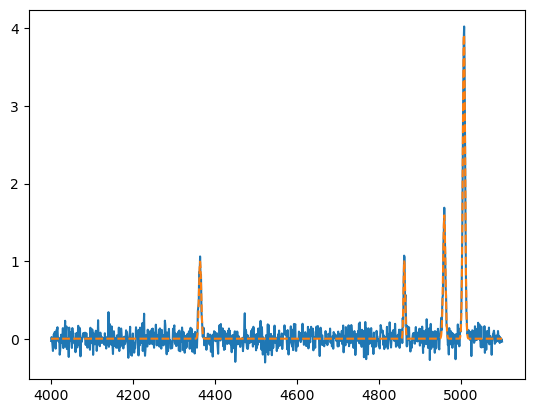

In [5]:
x= np.linspace(4000,5100,1000)
err = np.random.normal(0,0.5,1000)

y = line_model(x, 0, 4,3, 1, 4, 5007,1)+ np.random.normal(0, 0.1, size = 1000) +.01
a = old_fitting_line(x, y, err, 10, diagnose = False,save=False)
model = initial_fits(x,y,err,10)
print(model)
plt.figure()
plt.plot(x,y)
plt.plot(x, line_model(x,*model),linestyle='--')
plt.show()



In [79]:
a[-1]

,b,sigma_OIII,sigma_hbeta,OIII4363 Amplitude,OIII5007 Amplitude,OIII5007 Center,h_beta Amplitude,LnL
0,0.009664,3.938975,2.977620,0.993584,4.046428,5007.043071,1.190551,-5.039169
1,0.010106,3.995648,2.938756,1.017924,3.999121,5007.009198,1.052386,-0.399458
2,0.009866,4.018439,3.010772,0.977404,3.975596,5006.946219,0.789788,-6.275483
3,0.010206,4.022242,3.083649,0.895988,3.982326,5006.974498,0.987852,-2.453377
4,0.010189,3.950944,2.935854,1.033995,4.026274,5007.040113,1.068261,-1.878483
...,...,...,...,...,...,...,...,...
9595,0.010185,4.051161,2.461866,1.001663,3.968657,5006.985452,1.188535,-2.818477
9596,0.010026,4.009893,3.196738,0.985605,3.988584,5006.972760,0.602926,-2.588214
9597,0.009791,4.042273,2.316687,0.939111,3.991532,5006.984329,1.538977,-2.234831
9598,0.010010,4.020447,2.634616,0.988264,3.988554,5007.002596,1.220741,-0.996294


In [6]:
main_table = Table.read('MAIN_TABLE_CORRECTED.fits')
confirmed_redshifts_for_filtered_restframe = main_table['NEW_REDSHIFT'].value
obs_wavelength = main_table['OBS_WAVELENGTH']
redshift = main_table['NEW_REDSHIFT']
flux = main_table['FLUX']
source_name = main_table['SOURCE_NAME']
flux_error = main_table['FLUX_ERROR']
flags = main_table['FLAGS']
R_values= main_table['R VALUES']

In [15]:
# for i in range(1, 10):
#     z_mask = (main_table['NEW_REDSHIFT'] > i) & (main_table['NEW_REDSHIFT'] < i+1) & (main_table['R VALUES'] == "Yes") & (main_table['FLAGS']==True)
#     check = main_table[z_mask]

#     plt.figure(figsize = (12, 7))
#     for x, y in zip(check['REST_FRAME_WAVELENGTH']*10000, check['FLUX_INSTRINSIC']):
#         plt.plot(x, y)
#         plt.xlim(3000, 10000)
#     plt.show()

## random sampling with replacement

In [7]:
def OIII_ratio(oiii4363, oiii4960, oiii5007):
    """Calculate the logarithmic OIII ratio."""
    ratio = np.log10(oiii4363 / (oiii4960 + oiii5007))
    return ratio

def effective_temp(x):
    """Calculate the effective temperature from the OIII ratio."""
    log_Te = (3.5363 + 7.2939 * x) / (1.0000 + 1.6298 * x - 0.1221 * (x ** 2) - 0.0074 * (x ** 3))
    T_e = 10 ** log_Te
    return T_e

def metallicity(T_e):
    """Calculate the metallicity as 12 + log(O/H)."""
    t_e = T_e / 1e4  # Scale temperature to 10^4 K units
    O_H = 9.72 - 1.7 * t_e + 0.32 * (t_e ** 2)
    return O_H

In [10]:
#SLOW CODE
''' 
import numpy as np
from astropy.io import fits
import time
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

n_bootstrap = 2
# Load data
confirmed_redshifts_for_filtered_restframe = main_table['NEW_REDSHIFT'].value
names_for_filtered_restframe = main_table['SOURCE_NAME']
wavelength = (main_table['REST_FRAME_WAVELENGTH'].value) *10000
flux = main_table['FLUX_INSTRINSIC'].value
flux_error = main_table['FLUX_ERROR_CORRECTED'].value
R_values = main_table['R VALUES']
flags = main_table['FLAGS']
wt_avg_master = []
wt_err_master = []
stacked_wavelength = []
def removebad(flux, flux_error):
    flux_nan = ~np.isnan(flux)
    flux_error_nan = ~np.isnan(flux_error)
    master_mask = flux_nan & flux_error_nan
    return master_mask

for k in range(1, 10):
    z_mask = (confirmed_redshifts_for_filtered_restframe > k) & (confirmed_redshifts_for_filtered_restframe < k+1) & (R_values == 'Yes') & (flags==True)
    check = main_table[z_mask]


    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

    wavemin = 2000
    wavemax = 10000
    delwave = .01 # in AA
    gridwl = np.arange(wavemin, wavemax, delwave)
    nwave = len(gridwl)

    speccount = len(check)
    
    if speccount == 0:
        continue

    
    specall = np.zeros((nwave, speccount)) # speccount is # of galaxies in bin that we are stacking
    specerrall = np.zeros((nwave, speccount))  # for ex, speccount is # of galaxies between 2-3 redshift 
    
    t0 = time.time()
    
#     selected_spectra_flux_error = []
#     selected_spectra_redshift = []
#     selected_spectra_wavelength = []
#     selected_spectra_flux = []
    
    for b in range(n_bootstrap):
        rand_idx = np.random.randint(0, speccount, size=speccount)
        
        rand_redshift = check["NEW_REDSHIFT"][rand_idx]
        rand_flux = check["FLUX_INSTRINSIC"][rand_idx]
        rand_flux_error = check["FLUX_ERROR_CORRECTED"][rand_idx]
        rand_wavelength = check["REST_FRAME_WAVELENGTH"][rand_idx]
        
        for i in range(speccount):
            
            redshift = rand_redshift[i]

            # Access individual spectrum for the current galaxy
            current_flux = rand_flux[i]  # flux[i] is a 1D array for this galaxy
            current_flux_error = rand_flux_error[i]  # flux_error[i] is a 1D array for this galaxy
            current_wavelength = (rand_wavelength*10000)[i]  # corresponding wavelength array for this galaxy

            # Remove bad pixels using removebad function
            goodpix = removebad(current_flux, current_flux_error)
            current_flux = current_flux[goodpix]
            current_flux_error = current_flux_error[goodpix]
            current_wavelength = current_wavelength[goodpix]  # Apply goodpix to current_wavelength

            # Subtract continuum
            continuum = signal.medfilt(current_flux, kernel_size=951)
            subtract_continuum = current_flux - continuum
            #subtract_continuum_flux_error = current_flux_error - continuum

            ldist = cosmo.luminosity_distance(redshift).to(u.cm)  # Compute luminosity distance
            lspec = ldist * ldist * 4 * np.pi * (1 + redshift) * subtract_continuum
            lspecerr = ldist * ldist * 4 * np.pi * (1 + redshift) * current_flux_error  # Luminosity error

            UNDEF = -999.
            gridspec = np.interp(gridwl, current_wavelength, lspec.value, left=UNDEF, right=UNDEF)  # Interpolating the flux
            gridspecerr = np.interp(gridwl, current_wavelength, lspecerr.value, left=UNDEF, right=UNDEF)  # Interpolating the error
            specall[:, i] = gridspec
            specerrall[:, i] = gridspecerr

        wt_avg = np.zeros(nwave)
        wt_err = np.zeros(nwave)

            # Stacking
        for j in range(nwave):  # to stack pixels
            speccol = specall[j, :]
            specerrcol = specerrall[j, :]
            good = np.where(speccol != UNDEF)
            ngood = len(speccol[good])

            if ngood == 0:
                continue  # If no good pixels, skip

            speccol = speccol[good]
            specerrcol = specerrcol[good]

            weight = 1 / (specerrcol * specerrcol)
            wt_avg[j] = np.nansum(speccol * weight) / np.nansum(weight)
            wt_err[j] = np.sqrt(1. / np.nansum(weight))

        wt_avg_master.append(wt_avg)    
        wt_err_master.append(wt_err)    
        stacked_wavelength.append(gridwl)

        # Plot the weighted average stacked spectrum for each bin
        #z_range = key.replace('_', '<z<')
        plt.figure(figsize=(10, 3))
        plt.axvline(OIII4960, c='k', label='OIII4960', linewidth=.5, ls='--', alpha=0.6)
        plt.text(OIII4960 - 150, max(wt_avg) * 0.7, 'OIII4960', rotation=90, verticalalignment='bottom', alpha=0.6)

        plt.axvline(OIII5007, c='k', label='OIII5007', linewidth=.5, ls='--', alpha=0.4)
        plt.text(OIII5007 + 100, max(wt_avg) * 0.7, 'OIII5007', rotation=90, verticalalignment='bottom', alpha=0.6)

        plt.axvline(OIII4363, c='k', label='OIII4363', linewidth=.5, ls='--', alpha=0.4)
        plt.text(OIII4363 + 75, max(wt_avg) * 0.7, 'OIII4363', rotation=90, verticalalignment='bottom', alpha=0.6)

        plt.plot(gridwl, wt_avg, lw=1, c='teal')
        plt.xlim(3000, 10000)
        plt.title(f'Stacked Spectra for {k} < z < {k+1}')
        plt.xlabel('Wavelength')
        plt.ylabel('Weighted Average')
        plt.show()
'''

' \nimport numpy as np\nfrom astropy.io import fits\nimport time\nfrom astropy.cosmology import FlatLambdaCDM\nimport astropy.units as u\nfrom scipy import signal\nimport matplotlib.pyplot as plt\n%matplotlib inline\n\nn_bootstrap = 2\n# Load data\nconfirmed_redshifts_for_filtered_restframe = main_table[\'NEW_REDSHIFT\'].value\nnames_for_filtered_restframe = main_table[\'SOURCE_NAME\']\nwavelength = (main_table[\'REST_FRAME_WAVELENGTH\'].value) *10000\nflux = main_table[\'FLUX_INSTRINSIC\'].value\nflux_error = main_table[\'FLUX_ERROR_CORRECTED\'].value\nR_values = main_table[\'R VALUES\']\nflags = main_table[\'FLAGS\']\nwt_avg_master = []\nwt_err_master = []\nstacked_wavelength = []\ndef removebad(flux, flux_error):\n    flux_nan = ~np.isnan(flux)\n    flux_error_nan = ~np.isnan(flux_error)\n    master_mask = flux_nan & flux_error_nan\n    return master_mask\n\nfor k in range(1, 10):\n    z_mask = (confirmed_redshifts_for_filtered_restframe > k) & (confirmed_redshifts_for_filtered_rest

conducting orders of operations on array of the same length is a faster process that creating for loops. for 10/30, work on adding metallicity and old_fitting_line function onto the stacking code. 1000 metallcity saved into 1 array. then do 16%, 50%, 84%.

0


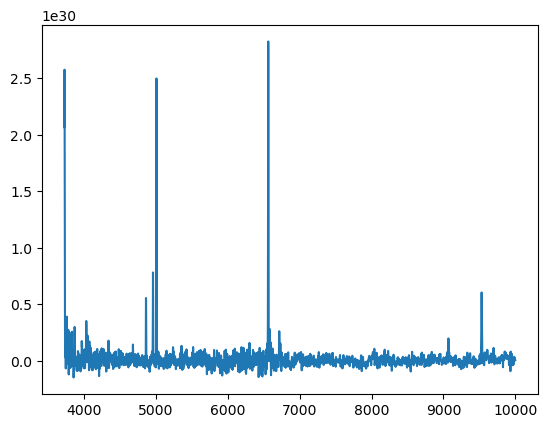

[8.56685216802451e+26, 0, 0, 8.87436488008282e+28, 1.250114743882115e+30, 4996.843, 2.77765138377973e+29]
[3.426740867209804e+27, 4.700423042299917, 4.700423042299917, 3.549745952033128e+29, 5.00045897552846e+30, 5016.843, 1.111060553511892e+30]
[1.59897755e+27 2.90630019e+00 2.56964235e+00 1.39509078e+29
 2.30561971e+30 5.00707151e+03 6.02963771e+29]
Flux 5007: 0       1.717969e+31
1       1.691269e+31
2       1.722835e+31
3       1.785586e+31
4       1.703930e+31
            ...     
9595    1.712371e+31
9596    1.715556e+31
9597    1.717114e+31
9598    1.717204e+31
9599    1.714687e+31
Length: 9600, dtype: float64
Flux 4960: 0       6.871877e+30
1       6.765074e+30
2       6.891340e+30
3       7.142344e+30
4       6.815721e+30
            ...     
9595    6.849485e+30
9596    6.862225e+30
9597    6.868455e+30
9598    6.868817e+30
9599    6.858748e+30
Length: 9600, dtype: float64
Flux 4363: 0       4.516703e+29
1       5.498006e+29
2       3.005763e+29
3       3.545233e+29
4       4

NameError: name 'avg_oiii_metallicity_three' is not defined

In [ ]:
# Bootstrap iterations
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy import signal

# Constants and initializations
n_bootstrap = 1
wavemin, wavemax, delwave = 2000, 10000, 0.01
gridwl = np.arange(wavemin, wavemax, delwave)
nwave = len(gridwl)
q_master = []

wave_mask = (4200 <= gridwl) & (gridwl <= 5200)

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
scaling_factor_const = 4 * np.pi  # Precompute constant factor
all_metallicities_three = []

# Precompute the wavelength grid
stacked_spectra, stacked_errors = [], []

def removebad(flux, flux_error):
    return ~np.isnan(flux) & ~np.isnan(flux_error)

for k in range(1, 10):
    z_mask = (confirmed_redshifts_for_filtered_restframe > k) & \
             (confirmed_redshifts_for_filtered_restframe < k + 1) & \
             (R_values == 'Yes') & (flags == True)
    check = main_table[z_mask]
    speccount = len(check)

    if speccount == 0:
        continue

    # Initialize arrays for stacking spectra
    redshifts = check["NEW_REDSHIFT"]
    flux_data = check["FLUX_INSTRINSIC"]
    flux_error_data = check["FLUX_ERROR_CORRECTED"]
    wavelengths = (check["REST_FRAME_WAVELENGTH"] * 10000)

    # Precompute luminosity distance scaling for this redshift bin
    ldist = cosmo.luminosity_distance(redshifts).to(u.cm).value
    scaling_factors = scaling_factor_const * (ldist ** 2) * (1 + redshifts)

    interpolated_fluxes, interpolated_errors = [], []

    # Preprocess all spectra and interpolate once
    for i in range(speccount):
        flux = flux_data[i] * 1e-23 #Converting Jy to erg/s/cm^2/Hz
        flux_error = flux_error_data[i] * 1e-23
        wavelength = wavelengths[i]

        # Mask bad pixels and interpolate once
        goodpix = removebad(flux, flux_error)
        flux = flux[goodpix]
        flux_error = flux_error[goodpix]
        wavelength = wavelength[goodpix]

        # Subtract continuum with smaller kernel size
        continuum = signal.medfilt(flux, kernel_size=151)
        subtract_continuum = flux - continuum

        # Scale flux and error using precomputed scaling factors
        scaled_flux = scaling_factors[i] * subtract_continuum
        scaled_flux_error = scaling_factors[i] * flux_error

        interpolated_flux = np.interp(gridwl, wavelength, scaled_flux, left=np.nan, right=np.nan)
        interpolated_flux_error = np.interp(gridwl, wavelength, scaled_flux_error, left=np.nan, right=np.nan)
        interpolated_fluxes.append(interpolated_flux)
        interpolated_errors.append(interpolated_flux_error)

    # Convert to arrays for efficient access in bootstrap
    interpolated_fluxes = np.array(interpolated_fluxes)
    interpolated_errors = np.array(interpolated_errors)


    for b in range(n_bootstrap):
        print(b)
        # Random sampling with replacement
        rand_idx = np.random.randint(0, speccount, size=speccount)
        sampled_flux = interpolated_fluxes[rand_idx]
        sampled_flux_error = interpolated_errors[rand_idx]
        #need to add things for commit
        # Weighted average and error computation
        wt_avg = np.nanmean(sampled_flux, axis=0)
        wt_err = np.nanstd(sampled_flux_error, axis=0)
        plt.figure()
        plt.plot(gridwl[wave_mask], wt_avg[wave_mask])
        plt.show()
        # Perform metallicity calculation


        
        all_metallicities_three = old_fitting_line(gridwl[wave_mask], 
                                                   wt_avg[wave_mask], 
                                                   wt_err[wave_mask], 15, save=False, diagnose=False)
        
        print(all_metallicities_three)


    # Compute percentiles for all bootstrapped metallicities
    avg_oiii_metallicity = np.percentile(all_metallicities_three, q=(16, 50, 84), axis=0)
    q_master.append(avg_oiii_metallicity_three)


In [16]:
line_model?

Signature:
line_model(
    x,
    b,
    sigma,
    sigma_h_beta,
    amp_4363,
    amp_5007,
    mu5007,
    amp_hbeta,
)
Docstring: Emission Line model using Gaussian and the continuum
File:      /var/folders/t2/6968g8md2c9g1mm1h0p9nxl588s4s1/T/ipykernel_49904/1421801122.py
Type:      function

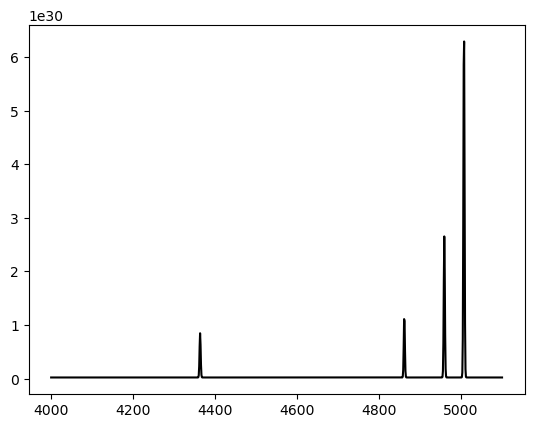

In [20]:
# b: 1.96480598069553e+28
# sigma: 1.9262297646834965
# sigma_beta: 1.8532158299445203
# OIII4363 Amplitude: 8.260239232657188e+29
# OIII5007 Amplitude: 6.594670210214424e+30
# Center OIII5007: 5007.0761868513455
# H_beta Amplitude: 1.1713783746499128e+30
xarr = np.linspace(4000, 5100, 1000)
model = line_model(xarr, 1.96480598069553e+28, 1.9262297646834965, 1.8532158299445203, 8.260239232657188e+29, 6.594670210214424e+30, 5007.0761868513455, 1.1713783746499128e+30)

plt.figure()
plt.plot(xarr, model, color = 'black')
plt.show()


In [ ]:
q_master = np.array(q_master)
redshift_bins = ['1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9']

fig, ax = plt.subplots(figsize=(10, 6))
lower = q_master[:,1] - q_master[:,0]
upper= q_master[:,2] - q_master[:,1]
error = [lower,upper]

ax.errorbar(
    range(1, 9), q_master[:,1], yerr=error, fmt='o-', 
    capsize=5, capthick=2, elinewidth=2,c = 'purple'
)

# Set x-axis labels and ticks
ax.set_xticks(range(1, 9))
ax.set_xticklabels(redshift_bins)

# Set axis labels and title
ax.set_xlabel('z')
ax.set_ylabel('12 + log(O/H)')
ax.set_title('Metallicity vs Redshift Bin')

# Add a legend and grid
ax.grid(True)

# Show the plot
plt.show()


In [32]:
q_master

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])]

In [ ]:
stacked_table = Table({'FLUX':wt_avg_master,
                     'WAVELENGTH':stacked_wavelength,
                     'FLUX_ERROR':wt_err_master})
stacked_table.write('STACKED_SPECTRA.fits',overwrite=True) 

In [30]:
stacked_table = Table.read('STACKED_SPECTRA.fits')
stacked_table

FLUX,WAVELENGTH,FLUX_ERROR
float64,float64,float64
